In [7]:
#!pip install --upgrade keras

import sys
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.patches as patches
from matplotlib import pyplot
import pickle

In [8]:
protext_path = "/faceml/opencv/deploy.prototxt"
model_path = "/faceml/opencv/res10_300x300_ssd_iter_140000.caffemodel"
embedder_path = "/faceml/opencv/openface_nn4.small2.v1.t7"

model_folder='/images/whatsapp/training/'

faces_file = 'familycv2.npz'
embeddings_file = "familyembedcv2.npz"
recognizer_file = "recognizer.pickle"
labelencoder_file = "labelencoder.pickle"

In [9]:
def load_caffe_model():
    # load the model
    return cv2.dnn.readNetFromCaffe(protext_path, model_path)

def load_embedder():
    return cv2.dnn.readNetFromTorch(embedder_path)

In [10]:
from PIL import Image, ImageOps 
from numpy import asarray


def blob_from_image(imagearray):
    return cv2.dnn.blobFromImage(cv2.resize(imagearray, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    

def load_image(filename):
    try:
        image = cv2.imread(filename)
        (h, w) = image.shape[:2]
        return h,w,image
    except:
        return (None,)*3
    
# extract a single face from a given photograph
def extract_all_faces(model,filename):
    x1,y1,x2,y2 = list(),list(),list(),list()
    faces=list()
    h,w,image = load_image(filename)
    if (image is None):
        return (None,)*5
    blob = blob_from_image(image)
    model.setInput(blob)
    detections = model.forward()
    if (len(detections) > 0):
        # loop over the detections
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with the
            # prediction
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the `confidence` is
            # greater than the minimum confidence
            if confidence > 0.5:
                # compute the (x, y)-coordinates of the bounding box for the
                # object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                face = image[startY:endY, startX:endX]
                (fH, fW) = face.shape[:2]
                if fW < 20 or fH < 20:
                    continue
                x1.append(startX)
                y1.append(startY)
                x2.append(endX)
                y2.append(endY)
                face_array = asarray(face)
                faces.append(face_array)
        return  x1, y1, x2, y2, faces
    else:
        return (None,)*5


# extract a single face from a given photograph
def extract_face(model,filename):    
    (x1,y1,x2,y2,faces) = extract_all_faces(model, filename)
    if (faces is None or len(faces)==0):
        return (None,)*5
    return x1[0],y1[0],x2[0],y2[0],faces[0]
    
    
def resize_image(src_image, size=(300,300)): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

    

In [11]:
def show_image(image_file, x1, y1, x2, y2):
    h,w,im = load_image(image_file)
    fig,ax = pyplot.subplots(1)
    pyplot.figure(figsize=(320,320))
    ax.imshow(im)
    for i in range(len(x1)):
        rect = patches.Rectangle((x1[i],y1[i]),x2[i]-x1[i],y2[i]-y1[i],linewidth=1,edgecolor='r',facecolor='none', label=i)
        centerx = x1[i] + (x2[i]-x1[i])/2
        centery = y1[i] + (y2[i]-y1[i])/2
        ax.text(centerx, centery,str(i))
        # Add the patch to the Axes
        ax.add_patch(rect)
    pyplot.show()

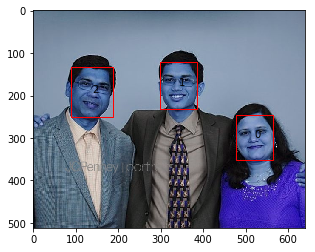

<Figure size 23040x23040 with 0 Axes>

0 [  8.01624296e-04   4.91929061e-03   9.94279085e-01] sangeeta 0.994279085098
1 [ 0.59543432  0.38472798  0.0198377 ] atharva 0.595434321234
2 [ 0.14085918  0.82661991  0.03252091] samir 0.82661991466


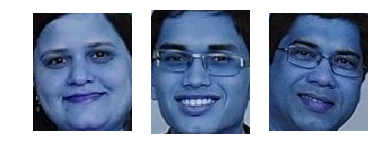

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pickle
import imutils

model =load_caffe_model()
embedder =load_embedder()

image_file='/faceml/sampleimages/image1.jpg'
h,w,image = load_image(image_file)

recognizer = pickle.loads(open(model_folder + recognizer_file, "rb").read())
le = pickle.loads(open(model_folder + labelencoder_file, "rb").read())

image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300),
    (104.0, 177.0, 123.0), swapRB=False, crop=False)

model.setInput(imageBlob)
detections = model.forward()


x1, y1, x2, y2, faces = extract_all_faces(model, image_file)
show_image(image_file,x1, y1, x2, y2)
for i in range(len(x1)):
    pyplot.subplot(1, len(x1), i+1)
    pyplot.axis('off')
    pyplot.imshow(faces[i])
    faceBlob = cv2.dnn.blobFromImage(faces[i], 1.0 / 255, (96, 96),
        (0, 0, 0), swapRB=True, crop=False)
    embedder.setInput(faceBlob)
    vec = embedder.forward()

    # perform classification to recognize the face
    preds = recognizer.predict_proba(vec)[0]
    j = np.argmax(preds)
    proba = preds[j]
    name = le.classes_[j]
    print(i, preds, name, proba)
